In [174]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [175]:
pip install vaderSentiment

In [176]:
import warnings
warnings.filterwarnings('ignore')
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation
import nltk
import tensorflow as tf
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

In [177]:
 import nltk
 nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [178]:
dfNews = pd.read_csv('/content/drive/MyDrive/Combined_News_DJIA.csv')
dfStock = pd.read_csv('/content/drive/MyDrive/upload_DJIA_table.csv')

In [179]:
dfNews

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

In [180]:
merge = dfNews.merge(dfStock, how='inner', on='Date', left_index = True)

In [181]:
merge

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Volume,Adj Close
1988,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1987,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
1986,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""

In [182]:
headlines = []
for row in range(0, len(merge.index)):
    headlines.append(' '.join( str(x)for x in merge.iloc[row, 2:27]))

In [183]:
headlines[0]

'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war" b\'BREAKING: Musharraf to be impeached.\' b\'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\' b\'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\' b"Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing" b\'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\' b"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side" b"The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it." b\'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]\' b\'Did the U.S. Prep Georgia for War with Russia?\'

In [184]:
clean_headlines = []
for i in range(0, len(headlines)):
    clean_headlines.append(re.sub("b[(')]", '', headlines[i]))
    clean_headlines[i] = re.sub('b[(")]','',clean_headlines[i])
    clean_headlines[i] = re.sub("\'",'',clean_headlines[i])

In [185]:
clean_headlines[20]

'A French judge has ordered two branches of Scientologists and their leaders to stand trial for fraud   Russia in legal bid to ban South Park 60 Minutes Cut Ahmadinejads Statement, Solution Is Democracy in Israel/Palestine" U.S. drones kill 13 in missile attack in Pakistan Screw You, TSA: No Conviction on Key Charges in Liquid-Bomb Trial in London Scientology on trial for fraud in France! An EU ban on ads with sexist overtones? Another quasi-fictional piece of translucent flimflam Film Backs Afghans Claims of US Killings [of 90+ civilians] Giant Buddha found at Afghan site. After denying strenously the US reopens inquiry into Afghan attack that may have killed upto 90 civilians Videos surface showing dead Afghan children after US raid, sparking a new investigation "Consortium" of Media Execs to Canadian Green Party:  You can\\t participate in debate because the other parties don\\t want you there. Everything going wrong in the world .. in one convenient graphical display.  Until yester

In [186]:
merge['combined_news'] = clean_headlines
merge ['combined_news'][0]

'A 117-year-old woman in Mexico City finally received her birth certificate, and died a few hours later. Trinidad Alvarez Lira had waited years for proof that she had been born in 1898. IMF chief backs Athens as permanent Olympic host The president of France says if Brexit won, so can Donald Trump British Man Who Must Give Police 24 Hours Notice of Sex Threatens Hunger Strike: The man is the subject of a sexual risk order despite having never been convicted of a crime. 100+ Nobel laureates urge Greenpeace to stop opposing GMOs Brazil: Huge spike in number of police killings in Rio ahead of Olympics Austrias highest court annuls presidential election narrowly lost by right-wing candidate. Facebook wins privacy case, can track any Belgian it wants: Doesnt matter if Internet users are logged into Facebook or not Switzerland denies Muslim girls citizenship after they refuse to swim with boys at school: The 12- and 14-year-old will no longer be considered for naturalised citizenship because

In [187]:
merge.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Volume,Adj Close,combined_news
1988,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,Georgia downs two Russian warplanes as countri...
1987,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,Why wont America and Nato help us? If they won...
1986,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point 

In [188]:
def getsubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getpolarity(text):
    return TextBlob(text).sentiment.polarity

In [189]:
merge['subjectivity'] = merge ['combined_news'].apply(getsubjectivity)
merge['polarity'] = merge ['combined_news'].apply(getpolarity)

In [190]:
merge.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Volume,Adj Close,combined_news,subjectivity,polarity
1988,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,Georgia downs two Russian warplanes as countri...,0.267549,-0.048568
1987,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,Why wont America and Nato help us? If they won...,0.374806,0.121956
1986,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b

In [191]:
def getSIA(text):
    SIA = SentimentIntensityAnalyzer()
    sentiment = SIA.polarity_scores(text)
    return sentiment

In [192]:
compound = []
neg = []
pos = []
neu = []
SIA = 0
for i in range(0, len(merge['combined_news'])):
    SIA = getSIA(merge['combined_news'][i])
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    neu.append(SIA['neu'])
    pos.append(SIA['pos'])

In [193]:
merge['Compound'] = compound
merge['Negative'] = neg
merge['Neutral'] = neu
merge['Positive'] = pos

In [194]:
merge.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Volume,Adj Close,combined_news,subjectivity,polarity,Compound,Negative,Neutral,Positive
1988,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,Georgia downs two Russian warplanes as countri...,0.267549,-0.048568,-0.9982,0.212,0.728,0.061
1987,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,Why wont America and Nato help us? If they won...,0.374806,0.121956,-0.9977,0.205,0.733,0.062
1986,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia

In [195]:
merge.set_index('Date', inplace= True)
merge.head()

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Volume,Adj Close,combined_news,subjectivity,polarity,Compound,Negative,Neutral,Positive
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,Georgia downs two Russian warplanes as countri...,0.267549,-0.048568,-0.9982,0.212,0.728,0.061
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,Why wont America and Nato help us? If they won...,0.374806,0.121956,-0.9977,0.205,0.733,0.062
2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a 

In [196]:
stock_data = merge

In [197]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['Top1'	,'Top2'	,'Top3',	'Top4',	'Top5',	'Top6',	'Top7',	'Top8',	'Top9',	'Top10',	'Top11',	'Top12',	'Top13',	'Top14'	,'Top15',	'Top16',	'Top17',	'Top18',	'Top19'	,'Top20'	,'Top21',	'Top22'	,'Top23',	'Top24',	'Top25'], inplace=True, axis=1)

# rearranging the columns of the whole stock_data
stock_data = stock_data[['Open',	'High',	'Low',	'Close',	'Adj Close',	'Volume','Compound', 'Negative', 'Neutral', 'Positive', 'polarity', 'subjectivity']]

# displaying the final stock_data
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,Compound,Negative,Neutral,Positive,polarity,subjectivity
Date,,,,,,,,,,,,
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,11734.320312,212830000,-0.9982,0.212,0.728,0.061,-0.048568,0.267549
2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,11782.349609,183190000,-0.9977,0.205,0.733,0.062,0.121956,0.374806
2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,11642.469727,173590000,-0.9976,0.230,0.680,0.090,-0.044302,0.536234
2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,11532.959961,182550000,-0.9666,0.136,0.765,0.099,0.011398,0.364021
2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,11615.929688,159790000,-0.9818,0.162,0.750,0.088,0.040677,0.375099


In [198]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 90% of data for training
train_end = int(data_to_use*0.90)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 1789
Number of records in Test Data: 200


In [199]:
stock_data.head(1)

,Open,High,Low,Close,Adj Close,Volume,Compound,Negative,Neutral,Positive,polarity,subjectivity
Date,,,,,,,,,,,,
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,11734.320312,212830000,-0.9982,0.212,0.728,0.061,-0.048568,0.267549


In [200]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
open_price = stock_data.iloc[start:total_data,0] #open
high = stock_data.iloc[start:total_data,1] #high
low = stock_data.iloc[start:total_data,2] #low
close_price = stock_data.iloc[start:total_data,3] #close
Adj_Close = stock_data.iloc[start:total_data,4] #Adj Close
volume = stock_data.iloc[start:total_data,5] #volume
compound = stock_data.iloc[start:total_data,6] #compound
negative = stock_data.iloc[start:total_data,7] #neg
neutral = stock_data.iloc[start:total_data,8] #neu
positive = stock_data.iloc[start:total_data,9] #pos
polarity = stock_data.iloc[start:total_data,10] #polarity
subjectivity = stock_data.iloc[start:total_data,11] #subjectivity
# printing close price
print("Close Price:")
close_price

Close Price:


Date
2008-08-11    11782.349609
2008-08-12    11642.469727
2008-08-13    11532.959961
2008-08-14    11615.929688
2008-08-15    11659.900391
                  ...     
2016-06-27    17140.240234
2016-06-28    17409.720703
2016-06-29    17694.679688
2016-06-30    17929.990234
2016-07-01    17949.369141
Name: Close, Length: 1988, dtype: float64

In [201]:
stock_data.head(1)

,Open,High,Low,Close,Adj Close,Volume,Compound,Negative,Neutral,Positive,polarity,subjectivity
Date,,,,,,,,,,,,
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,11734.320312,212830000,-0.9982,0.212,0.728,0.061,-0.048568,0.267549


In [202]:
# concatenating the captured training data into a dataframe
data = pd.concat([open_price, high, low, close_price,Adj_Close ,volume, compound, negative, neutral, positive,polarity, subjectivity], axis=1)

# setting column names of the revised stock data
data.columns = ['Open','High','Low','Close','Adj Close','Volume','Compound','Negative','Neutral','Positive','polarity','subjectivity']

# dropping nulls
data = data.dropna()    
data.head(1)

,Open,High,Low,Close,Adj Close,Volume,Compound,Negative,Neutral,Positive,polarity,subjectivity
Date,,,,,,,,,,,,
2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,11782.349609,183190000,-0.9977,0.205,0.733,0.062,0.121956,0.374806


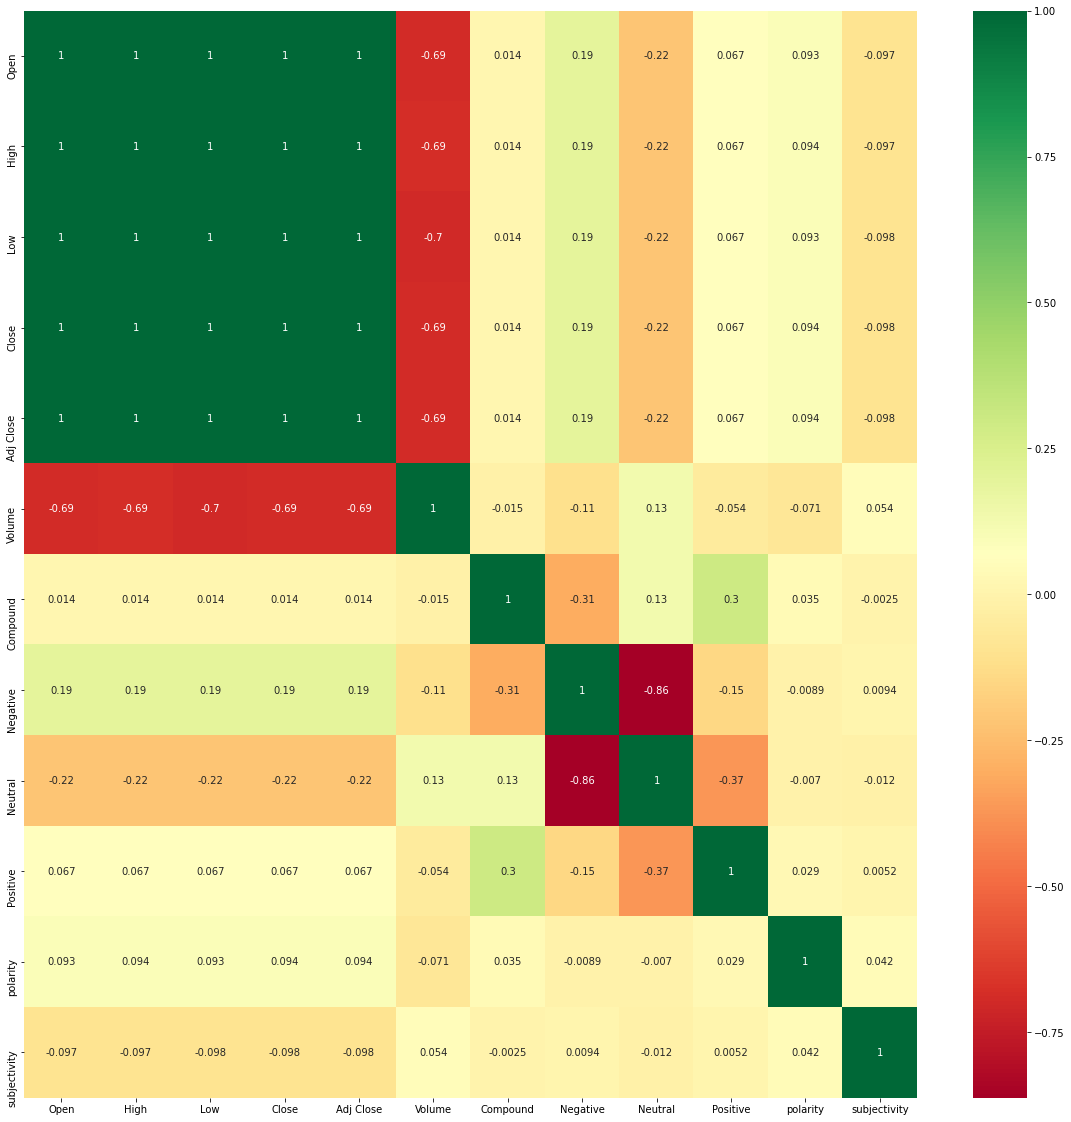

In [203]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [1148]:
# setting the features dataset for prediction  
cols = ['Open', 'High' ,'Low', 'Adj Close']
x = data[cols]
x

,Open,High,Low,Adj Close
Date,,,,
2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609
2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727
2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961
2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688
2008-08-15,11611.209961,11709.889648,11599.730469,11659.900391
...,...,...,...,...
2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234
2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703
2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688


In [1149]:
# setting the target variable as the shifted close_price
y = data['Close']
y

Date
2008-08-11    11782.349609
2008-08-12    11642.469727
2008-08-13    11532.959961
2008-08-14    11615.929688
2008-08-15    11659.900391
                  ...     
2016-06-27    17140.240234
2016-06-28    17409.720703
2016-06-29    17694.679688
2016-06-30    17929.990234
2016-07-01    17949.369141
Name: Close, Length: 1988, dtype: float64

In [1150]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.1191982 , -0.1139647 , -0.11789343, -0.11004706],
        [-0.11035557, -0.12852622, -0.13043485, -0.13382536],
        [-0.13565978, -0.15404976, -0.15554449, -0.15244102],
        ...,
        [ 0.85400454,  0.88887416,  0.86163383,  0.89499481],
        [ 0.89763797,  0.92771705,  0.90497699,  0.93499544],
        [ 0.93357943,  0.94004707,  0.9397336 ,  0.93828968]]),
 array([[-0.11004706],
        [-0.13382536],
        [-0.15244102],
        ...,
        [ 0.89499481],
        [ 0.93499544],
        [ 0.93828968]]))

In [1151]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (1789, 4) and y: (1789, 1)
Number of rows and columns in the Test set X: (198, 4) and y: (198, 1)


In [1152]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (1789, 4, 1)
Shape of Test set X: (198, 4, 1)


In [1153]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)
tf.random.set_seed(2016)
# setting the model architecture
model=Sequential()
model.add(LSTM(8,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.2))
model.add(Dense(1))
# printing the model summary
model.summary()

Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_124 (LSTM)              (None, 8)                 320       
_________________________________________________________________
dropout_124 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [1154]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=5, batch_size=19, verbose=1)

Epoch 1/5
85/85 [==============================] - 3s 10ms/step - loss: 0.2363 - val_loss: 0.2593
Epoch 2/5
85/85 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 6.6266e-04
Epoch 3/5
85/85 [==============================] - 0s 4ms/step - loss: 0.0142 - val_loss: 0.0045
Epoch 4/5
85/85 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.0051
Epoch 5/5
85/85 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0071


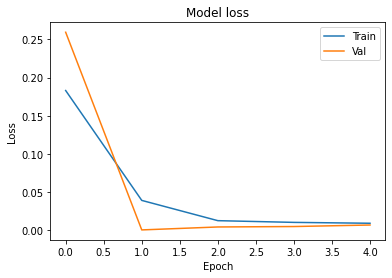

In [1155]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [1156]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[16337.427],
       [16283.319],
       [16206.687],
       [16116.615],
       [16200.982]], dtype=float32)

In [1157]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

198/198 [==============================] - 1s 5ms/step - loss: 0.0045
Train Loss = 0.0017
Test Loss = 0.0045


In [1158]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

In [1160]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 393.2075


In [1161]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 393.2075


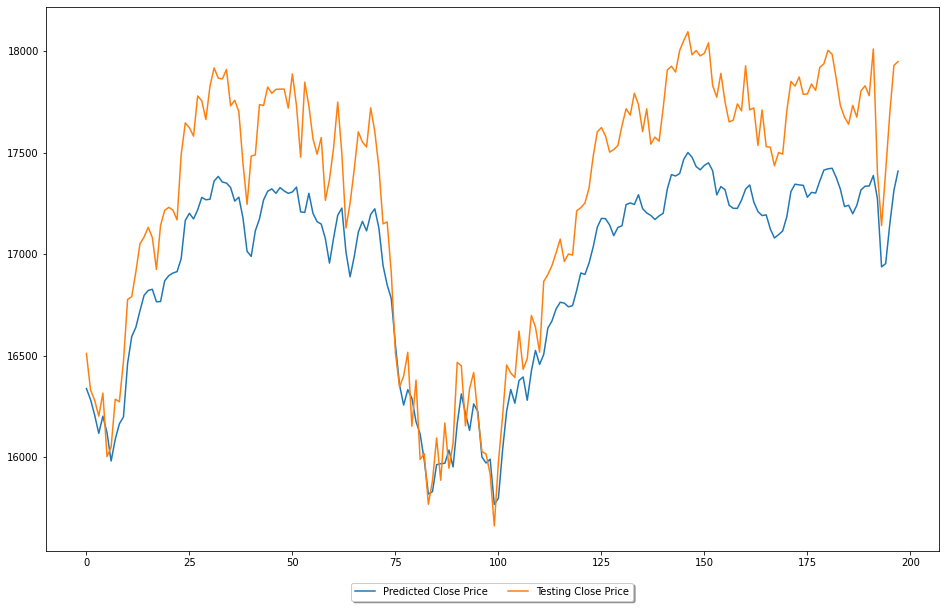

In [1162]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

In [799]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': predictions.flatten()})
df

,Actual,Predicted
0,16510.189453,16419.394531
1,16330.469727,16353.481445
2,16279.889648,16270.014648
3,16201.320312,16169.446289
4,16314.669922,16264.480469
...,...,...
193,17140.240234,17104.197266
194,17409.720703,17131.388672
195,17694.679688,17361.664062
196,17929.990234,17560.437500


In [899]:
# setting the features dataset for prediction  
cols = ['Negative','Open' ,'High', 'Low']
x2 = data[cols]
x2

,Negative,Open,High,Low
Date,,,,
2008-08-11,0.205,11729.669922,11867.110352,11675.530273
2008-08-12,0.230,11781.700195,11782.349609,11601.519531
2008-08-13,0.136,11632.809570,11633.780273,11453.339844
2008-08-14,0.162,11532.070312,11718.280273,11450.889648
2008-08-15,0.093,11611.209961,11709.889648,11599.730469
...,...,...,...,...
2016-06-27,0.204,17355.210938,17355.210938,17063.080078
2016-06-28,0.150,17190.509766,17409.720703,17190.509766
2016-06-29,0.137,17456.019531,17704.509766,17456.019531


In [900]:
# setting the target variable as the shifted close_price
y2 = data['Close']
y2

Date
2008-08-11    11782.349609
2008-08-12    11642.469727
2008-08-13    11532.959961
2008-08-14    11615.929688
2008-08-15    11659.900391
                  ...     
2016-06-27    17140.240234
2016-06-28    17409.720703
2016-06-29    17694.679688
2016-06-30    17929.990234
2016-07-01    17949.369141
Name: Close, Length: 1988, dtype: float64

In [901]:
# scaling the feature dataset
scaler_x2 = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x2 = np.array(x2).reshape((len(x2) ,len(cols)))
x2 = scaler_x2.fit_transform(x2)

# scaling the target variable
scaler_y2 = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y2 = np.array (y2).reshape ((len( y2), 1))
y2 = scaler_y2.fit_transform (y2)

# displaying the scaled feature dataset and the target variable
x2, y2

(array([[ 0.08396947, -0.1191982 , -0.1139647 , -0.11789343],
        [ 0.27480916, -0.11035557, -0.12852622, -0.13043485],
        [-0.44274809, -0.13565978, -0.15404976, -0.15554449],
        ...,
        [-0.4351145 ,  0.85400454,  0.88887416,  0.86163383],
        [-0.03816794,  0.89763797,  0.92771705,  0.90497699],
        [ 0.24427481,  0.93357943,  0.94004707,  0.9397336 ]]),
 array([[-0.11004706],
        [-0.13382536],
        [-0.15244102],
        ...,
        [ 0.89499481],
        [ 0.93499544],
        [ 0.93828968]]))

In [902]:
# preparing training and test dataset
X_train2 = x2[0 : train_end,]
X_test2 = x2[train_end+1 : len(x2),]    
y_train2 = y2[0 : train_end] 
y_test2 = y2[train_end+1 : len(y2)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train2.shape, 'and y:', y_train2.shape)
print('Number of rows and columns in the Test set X:', X_test2.shape, 'and y:', y_test2.shape)

Number of rows and columns in the Training set X: (1789, 4) and y: (1789, 1)
Number of rows and columns in the Test set X: (198, 4) and y: (198, 1)


In [903]:
# reshaping the feature dataset for feeding into the model
X_train2 = X_train2.reshape (X_train2.shape + (1,)) 
X_test2 = X_test2.reshape(X_test2.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train2.shape)
print('Shape of Test set X:', X_test2.shape)

Shape of Training set X: (1789, 4, 1)
Shape of Test set X: (198, 4, 1)


In [904]:
np.random.seed(2016)
tf.random.set_seed(2016)
model=Sequential()
model.add(LSTM(60,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [905]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
hist = model.fit(X_train2, y_train2, validation_split=0.1, epochs=5, batch_size=44)

Epoch 1/5
37/37 [==============================] - 3s 21ms/step - loss: 0.1541 - val_loss: 0.1171
Epoch 2/5
37/37 [==============================] - 0s 5ms/step - loss: 0.0223 - val_loss: 0.0231
Epoch 3/5
37/37 [==============================] - 0s 5ms/step - loss: 0.0130 - val_loss: 0.0087
Epoch 4/5
37/37 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0023
Epoch 5/5
37/37 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 6.6424e-04


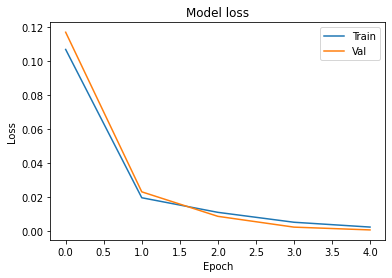

In [906]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [907]:
# performing predictions
predictions2 = model.predict(X_test2) 

# unscaling the predictions
predictions2 = scaler_y2.inverse_transform(np.array(predictions2).reshape((len(predictions2), 1)))

# printing the predictions
print('Predictions:')
predictions2[0:5]

Predictions:


array([[16408.479],
       [16318.366],
       [16261.779],
       [16094.153],
       [16334.491]], dtype=float32)

In [908]:
# unscaling the test feature dataset, x_test
X_test2 = scaler_x2.inverse_transform(np.array(X_test2).reshape((len(X_test2), len(cols))))

# unscaling the test y dataset, y_test
y_train2 = scaler_y2.inverse_transform(np.array(y_train2).reshape((len(y_train2), 1)))
y_test2 = scaler_y2.inverse_transform(np.array(y_test2).reshape((len(y_test2), 1)))

In [909]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test2 - predictions2),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 150.976


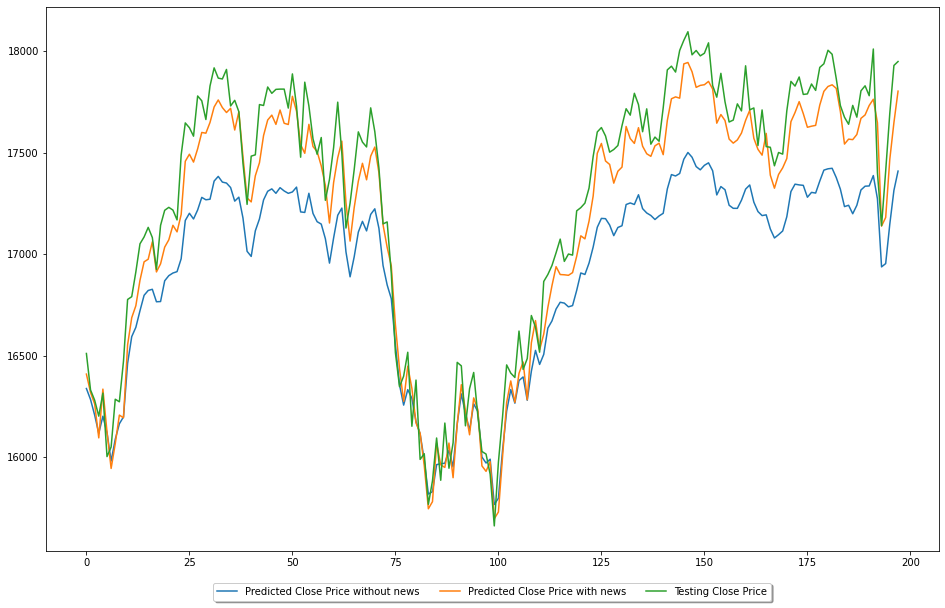

In [1163]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price without news")
plt.plot(predictions2, label="Predicted Close Price with news")
plt.plot([row[0] for row in y_test2], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.show()

In [911]:
df = pd.DataFrame({'Actual': y_test2.flatten(), 'Predicted': predictions2.flatten()})
df

,Actual,Predicted
0,16510.189453,16408.478516
1,16330.469727,16318.366211
2,16279.889648,16261.779297
3,16201.320312,16094.153320
4,16314.669922,16334.491211
...,...,...
193,17140.240234,17138.285156
194,17409.720703,17180.683594
195,17694.679688,17467.744141
196,17929.990234,17648.416016
